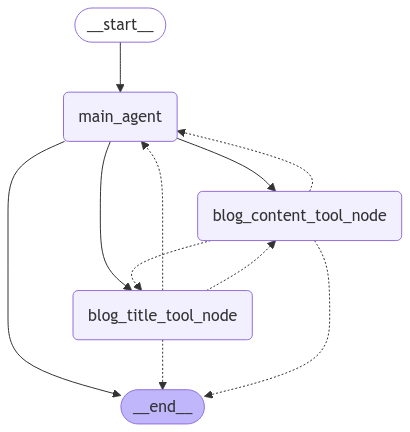

In [ ]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq 
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, START, MessageGraph
from langgraph.graph.state import StateGraph
load_dotenv()
from IPython.display import Image, display

#Load environment variables
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
api_key = os.getenv("GROQ_API_KEY")

#graph state
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

##llm
model = ChatGroq(groq_api_key=api_key,model_name="qwen-2.5-32b",streaming=True,temperature=0)


@tool
def create_blog_title(blog_concept:str):
    """generates title for a blog post"""
    model.invoke(f"generate a title for a blog for the concept {blog_concept}")
blog_title_tool_node = ToolNode([create_blog_title])

@tool
def create_blog_post(blog_title:str):
    """generates a blog post of 100 words based on a title"""
    model.invoke(f"generate a blog of 100 characters for the concept {blog_title}")
blog_content_tool_node = ToolNode([create_blog_post])

#Bind tools
model_with_tools = model.bind_tools([create_blog_title,create_blog_post])
def call_model(state):
        return {"messages": [model_with_tools.invoke(state["messages"])]}

def should_continue(state: State):
        if state["messages"][-1].tool_calls:
            return "tools"
        else:
            return END


#create graph
def create_graph():
    """Create a graph to call agents with tool, to generate blog"""

    graph_workflow = StateGraph(State)
    graph_workflow.add_node("main_agent", call_model)
    graph_workflow.add_edge(START, "main_agent")
    
    graph_workflow.add_node("blog_title_tool_node", blog_title_tool_node)
    graph_workflow.add_conditional_edges("blog_title_tool_node", should_continue)

    graph_workflow.add_node("blog_content_tool_node", blog_content_tool_node)
    graph_workflow.add_conditional_edges("blog_content_tool_node", should_continue)

    graph_workflow.add_edge("main_agent", "blog_title_tool_node")
    graph_workflow.add_edge("main_agent", "blog_content_tool_node")
    graph_workflow.add_edge("main_agent", END)

    agent = graph_workflow.compile()
    return agent
    
agent=create_graph()
display(Image(agent.get_graph().draw_mermaid_png()))

In [7]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Create a blog post on the topic of kolkata after british")]
messages = agent.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

AttributeError: 'ToolMessage' object has no attribute 'tool_calls'